##### Dungy fishing catch weight smoothed over a 15km neighbourhood

#### Summary
*  Aggregate fishing catch weight (5km spatial precision)
*  Calculate CPUE with number of traps
*  Smooth CPUE using inverse distance weighted neighbourhood (with 15km neighbourhood on 500 m raster)


In [2]:
# Import necessary modules
import numpy as np # for array math
import fiona # for shapes
import gdal # to build raster stats and pyramids
from matplotlib import pyplot as plt # for colourbar maps and histogram plot
import matplotlib.colors # for colour bins in raster map
from astropy.convolution import convolve # for focal sum with nan values
import glob # for listing files in a directory
from pathlib import Path # for handling file paths
import geopandas as gp # for loading shapefiles and extracting x,y values
import rasterio # for reading and writing rasters and spatial indexing of rasters
import rasterio.plot # to plot rasters
import rasterio.mask # to mask raster with polygon

In [3]:
g = gp.GeoDataFrame.from_file('FisheryLogs_2007_2017_soak_traps.shp')

In [4]:
# Remove records with zero value for number of traps
g = g[g['nm_trp_'] > 0.]
g

ID  YEAR         SPECIES MONTHLY STAT_AR BIMONTH  WEEKLY  \
0       374829  2007  DUNGENESS CRAB   20071      17  200712  200711   
1       373380  2007  DUNGENESS CRAB   20071      27  200712  200711   
2       398462  2007  DUNGENESS CRAB   20071      13  200712  200713   
3       383132  2007  DUNGENESS CRAB   20071       4  200712  200713   
4       374840  2007  DUNGENESS CRAB   20071      17  200711  200713   
...        ...   ...             ...     ...     ...     ...     ...   
266836  681653  2017  DUNGENESS CRAB   20179      16  201791  201793   
266837  681652  2017  DUNGENESS CRAB   20179      16  201791  201793   
266838  681823  2017  DUNGENESS CRAB   20179      16  201792  201791   
266839  680996  2017  DUNGENESS CRAB   20179      17  201791  201793   
266840  681580  2017  DUNGENESS CRAB   20179      17  201791  201793   

              DATE     VRN SPECIES_  ... DISCARD LANDING           PRICE_L  \
0       2007-01-03   30364      XKG  ...    None    None  4.14725253500724   
1       2007-01-07   24150      XKG  ...    None    None  3.04050420168067   
2       2007-01-16   29141      XKG  ...    None    None  3.58085106382979   
3       2007-01-16  311194      XKG  ...    None    None               2.9   
4       2007-01-17   30364      XKG  ...    None    None  3.63967213114754   
...            ...     ...      ...  ...     ...     ...               ...   
266836  2017-09-22  311490      XKG  ...    None    None  6.82730263157895   
266837  2017-09-22  311490      XKG  ...    None    None  6.82730263157895   
266838  2017-09-04  312375      XKG  ...    None    None    7.489336492891   
266839  2017-09-19   30364      XKG  ...    None    None                 6   
266840  2017-09-21  311289      XKG  ...    None    None  6.50126839167935   

                 NOMINAL PRICE_I           TOTAL_V       Catch HoursSk  \
0       124.417576050217  0.8481  146.701539971958   13.607760     264   
1       1155.39159663866  0.8481  1362.32943831937  172.364960      48   
2       35.8085106382979  0.8481  42.2220382481994    4.535920     312   
3                    8.7  0.8481  10.2582242660064    1.360776     168   
4       436.760655737705  0.8481  514.987213462687   54.431040      24   
...                  ...     ...               ...         ...     ...   
266836  273.092105263158  0.9833  277.730199596418   18.143680     192   
266837  273.092105263158  0.9833  277.730199596418   18.143680     192   
266838  898.720379146919  0.9833  913.983910451459   54.431040     288   
266839               300  0.9833  305.095087969084   22.679600      72   
266840  325.063419583968  0.9833  330.584175311672   22.679600     168   

       nm_trp_                        geometry  
0         21.0  POINT (1149383.654 467474.854)  
1         40.0   POINT (869843.865 611367.856)  
2          6.0  POINT (1004792.288 603260.560)  
3         40.0  POINT (718375.136 1013735.922)  
4         58.0  POINT (1157176.019 460815.065)  
...        ...                             ...  
266836    45.0  POINT (1143068.375 500198.477)  
266837    45.0  POINT (1142154.012 510147.793)  
266838    64.0  POINT (1145660.003 501368.566)  
266839    25.0  POINT (1153102.438 463063.823)  
266840    40.0  POINT (1174944.048 439602.937)  

[265930 rows x 43 columns]

In [5]:
# Subset, only dungeness, catch weight, soak hours and number of traps pulled
d = g[g["SPECIES_"] == 'XKG']
d = d[['Catch', 'HoursSk', 'nm_trp_', 'geometry']]
d = d.rename(columns={'Catch':'catch', 'HoursSk':'hours', 'nm_trp_':'traps',})
d

# Prep geo and catch, hours and traps array
catch_array = d['catch'].values
hrs_array = d['hours'].values
trap_array = d['traps'].values
geo = d.geometry.values

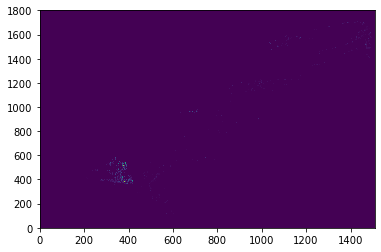

In [6]:
# Rasterize points

# Open bathy raster temporarily
with rasterio.open("Template_Raster.tif") as rast:
    # Get rows and column lengths
    rows = rast.shape[0]
    cols = rast.shape[1]
    # Get profile for output file
    profile = rast.profile
    # Create a grid for counting the frequency of points within each raster cell
    catch = np.zeros([rows, cols])
    hours = np.zeros([rows, cols])
    traps = np.zeros([rows, cols])

    for i in range(len(geo)):
        # Compute the row/col indices for each point based on x,y values
        r, c = rast.index( geo[i].x, geo[i].y )
        # Check if the index is out of range, if not the add count to grid
        if not (r < 0 or c < 0 or r >= rows or c >= cols):
            # Sum the catch and count the number of events
            catch[r,c] += catch_array[i]
            hours[r,c] += hrs_array[i]
            traps[r,c] += trap_array[i]
            
# Calculate CPUE by diving sum of catch by sum of hours and sum of traps
hours[hours == 0] = 'nan'
traps[traps == 0] = 'nan'
cpue = np.divide(catch, traps)
cpue = np.nan_to_num(cpue)
plt.pcolormesh(cpue)

In [8]:
# Smooth 15km

# Size
size = 29
# If neighbourhood size is an even number
if (size % 2) == 0:
    # Method for sequence when size is even
    lr = np.r_[0:1:size/2j]
    hor = np.concatenate([lr, np.flipud(lr)])
else:
    # Method for sequence when size is odd
    hor = abs( abs(np.mgrid[-1:1:size/1j]) - 1 )
# Weights array    
xw,yw = np.meshgrid(hor, hor.T)
weights = xw * yw

# Convolution
smooth=convolve(cpue, weights, normalize_kernel=False, boundary="extend", preserve_nan=False)
plt.pcolormesh(smooth)

# Write smoothed raster
with rasterio.Env():
    # Write raster
    output_file = 'Dungy_CPUE_15kmSmooth.tif'
    with rasterio.open(output_file, 'w', **profile) as dataset:
        dataset.write(smooth.astype(rasterio.float32), 1)

In [11]:
# Clip raster with footprint polygon
with fiona.open("Fisheries_Crab_Footprint_5km.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(output_file) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta    
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

clipped_file = 'Dungy_CPUE_15kmSmooth_Clipped.tif'
with rasterio.open(clipped_file, "w", **out_meta) as dest:
    dest.write(out_image)

In [12]:
# Build pyramids and calcualte stats for all rasters

# Loop through raster files
for r in [output_file,clipped_file]:
    # Set to 1 (read/write) mode to set pyramids and stats internally
    raster = gdal.Open(r, 1)
    gdal.SetConfigOption('COMPRESS_OVERVIEW', 'DEFLATE')
    # Build pyramids for all resolutions
    raster.BuildOverviews("NEAREST", [2,4,8,16,32,64,128,256,512,1024])
    # Caluclate stats
    raster.GetRasterBand(1).GetStatistics(0,1)
    del raster

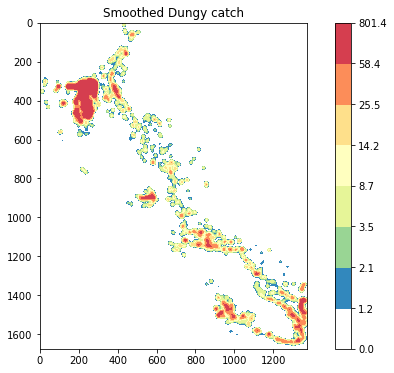

In [13]:
# Map of smoothed raster

# Load smoothed raster
with rasterio.open(clipped_file) as raster:
    # Read as array
    array = raster.read(1)
    array[np.isnan(array)] = 0 # low value (no data) to zero

    # Get quantile breaks
    f = array.flatten()
    f = f[f != 0] # without zeros
    q_breaks = np.arange(0.2, 1, 0.12).round(1).tolist()
    breaks = [0] + np.quantile(f, q_breaks).tolist() + [f.max()]
    # Get max value 
    maxval = array.max()
    # Set the colors
    cmap = matplotlib.colors.ListedColormap(['white','#3288bd','#99d594','#e6f598', 
                                             '#ffffbf','#fee08b','#fc8d59','#d53e4f'])
    # Define colors bins
    norm = matplotlib.colors.BoundaryNorm(breaks, 8)
    # Map
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title('Smoothed Dungy catch')
    img = ax.imshow(array, cmap=cmap, norm=norm)
    fig.colorbar(img, ax=ax);

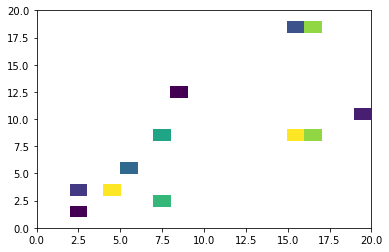

In [22]:
# --- testing


# even weighting
size=9
# If neighbourhood size is an even number
if (size % 2) == 0:
    # Method for sequence when size is even
    lr = np.r_[0:1:size/2j]
    hor = np.concatenate([lr, np.flipud(lr)])
else:
    # Method for sequence when size is odd
    hor = abs( abs(np.mgrid[-1:1:size/1j]) - 1 )
# Weights array    
xw,yw = np.meshgrid(hor, hor.T)
weights = xw * yw

# image
image = np.empty((20,20))
image[:] = np.nan
image
image[5,5] = 5;  image[2,7] = 9; image[12,8] = 1; image[3,2] = 3; image[1,2] = 1; image[3,4] = 13; 
image[8,7] = 8; image[18,15] = 4; image[8,16] = 11; image[8,15] = 13; image[10,19] = 2; image[18,16] = 11;
plt.pcolormesh(image)

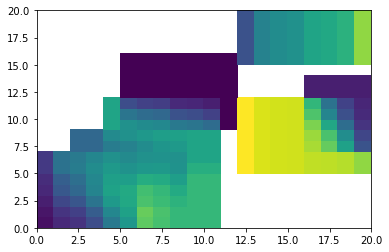

In [23]:
test2=convolve(image, weights, normalize_kernel=False, boundary="extend", preserve_nan=False)
plt.pcolormesh(test2)

In [24]:
test2=convolve(image, weights, normalize_kernel=False, boundary=None, preserve_nan=False)
plt.pcolormesh(test2)